**Reference:** [Building your First AI Agent with LangGraph (Analytics Vidhya)](https://courses.analyticsvidhya.com/courses/take/building-your-first-ai-agent-with-langgraph/assignments/60490544-project-creating-a-conversational-ai)

Now we can create Chatbot using LangGraph. Here in the Node Function we would call LLM to do a research on several topics.

### Initial Imports

In [ ]:
from langgraph.graph import StateGraph, MessagesState, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image
from dotenv import load_dotenv, find_dotenv
from typing import Annotated
from langgraph.graph.message import add_messages
import os

In [2]:
# ============================================================================
# SETUP: Import LLM Helper Functions
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath(".."))

# Import our LLM factory functions
# - get_groq_llm(): Creates a Groq-hosted LLM (fast inference)
# - get_openai_llm(): Creates an OpenAI GPT model
from helpers.utils import get_groq_llm, get_openai_llm

print("LLM helpers imported successfully!")

LLM helpers imported successfully!


## Step 2: Create Tools and Augment the LLM

Same as before - we create tools and bind them to the LLM.
The difference comes in how we **structure the graph** to create a feedback loop.

### Tool Creation Recap
1. Define Python function with `@tool` decorator
2. Write clear docstring (helps LLM decide when to use it)
3. Add type hints for parameters
4. Bind tools to LLM with `bind_tools()`

Here we define our custom search tool and then bind it to the LLM to augment the LLM.

### Why Do We Need Both `bind_tools()` AND `ToolNode`?

A common question: *"If we're using tools in ToolNode, why do we also need to bind them to the LLM?"*

These serve **two different roles**:

| Component | Role | What it does |
|-----------|------|--------------|
| `llm.bind_tools()` | **Decision Maker** | Tells the LLM what tools exist so it can *decide* when to call them |
| `ToolNode` | **Executor** | Actually *runs* the tool functions when instructed |

#### The Flow

```
User: "What's the latest news on OpenAI?"
           │
           ▼
┌─────────────────────────────┐
│  LLM (with bound tools)     │  ← Knows about tavily_search
│  "I need to search for this"│
│  Generates: tool_calls=[..] │  ← Outputs structured tool call request
└─────────────────────────────┘
           │
           ▼
┌─────────────────────────────┐
│  should_continue()          │
│  Checks: tool_calls exist?  │  ← YES → route to "tools"
└─────────────────────────────┘
           │
           ▼
┌─────────────────────────────┐
│  ToolNode                   │  ← Receives the tool_call
│  Actually runs the search   │  ← Returns search results
└─────────────────────────────┘
           │
           ▼
┌─────────────────────────────┐
│  LLM (processes results)    │
│  Generates final answer     │
└─────────────────────────────┘
```

#### Why Both Are Needed

**Without `bind_tools()`:**
- The LLM has **no idea** what tools are available
- It cannot generate `tool_calls` because it doesn't know the tool schemas (name, description, parameters)
- `last_message.tool_calls` will **always be empty**
- The ToolNode will **never be reached**

**Without `ToolNode`:**
- The LLM can request tool calls, but nothing will execute them
- You'd have to manually parse and run the tools

#### Analogy

Think of it like a chef and a kitchen:

- **`bind_tools()`** = Giving the chef a menu of available ingredients. The chef *decides* what to cook.
- **`ToolNode`** = The kitchen that *prepares* the dish when the chef orders it.

Without the menu, the chef doesn't know what's available. Without the kitchen, orders can't be fulfilled.

In [4]:
# ============================================================================
# CREATE THE LLM AND CHATBOT GRAPH
# ============================================================================

# -----------------------------------------------------------------------------
# Step 1: Initialize the LLM
# We use Groq for fast inference, but you can swap to OpenAI
# -----------------------------------------------------------------------------
llm = get_groq_llm()  # Fast, open-source models hosted by Groq
# Alternative: llm = get_openai_llm()  # OpenAI's GPT models

print(f"LLM initialized: {llm.model_name if hasattr(llm, 'model_name') else 'Groq LLM'}")

search_tool = TavilySearchResults(max_results=5)
tools = [search_tool]

# Bind tools to the LLM
# This creates a new LLM that can decide to call tools when needed
llm_with_tools = llm.bind_tools(tools=tools)

print(f"Agent equipped with {len(tools)} tool(s): {[t.name for t in tools]}")

LLM initialized: llama-3.3-70b-versatile
Agent equipped with 1 tool(s): ['tavily_search_results_json']


In [5]:
# ============================================================================
# TEST: Verify the augmented LLM can make tool calls
# ============================================================================
# Let's test that our LLM is properly augmented and can make tool calls
# For queries requiring current information, the LLM should return tool_calls

print("Testing augmented LLM with tool-calling capability:")
print("-" * 50)
print("Query: 'what is the latest news on nvidia'")
print("Expected: LLM should return tool_calls (not direct answer)\n")

response = llm_with_tools.invoke('what is the latest news on nvidia')

# Check if the LLM called any tools
if response.tool_calls:
    print("✓ LLM correctly decided to call tools!")
    print(f"Tool calls: {response.tool_calls}")
else:
    print("Note: LLM answered directly (no tool calls needed)")
    print(f"Response: {response.content}")

Testing augmented LLM with tool-calling capability:
--------------------------------------------------
Query: 'what is the latest news on nvidia'
Expected: LLM should return tool_calls (not direct answer)

✓ LLM correctly decided to call tools!
Tool calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'NVIDIA latest news'}, 'id': '9q1ymk3c3', 'type': 'tool_call'}]


## Step 3: Create the Graph with the Tool-Use Agentic System

### The Critical Difference: The Feedback Loop

**This is where we add the feedback loop that makes it an Agent!**

In the previous notebook (Augmented LLM), tool results went directly to END:
```
LLM → Tool → END (raw results)
```

In this notebook (AI Agent), we add a feedback loop:
```
LLM → Tool → LLM (processes results) → END or more tools
```

### Key Components

| Component | Purpose |
|-----------|---------|
| **tool_calling_llm** | Node that calls the augmented LLM |
| **tools** (ToolNode) | Executes tool calls |
| **tools_condition** | Routes based on whether LLM made tool calls |
| **Feedback loop** | Routes tool results back to LLM |

### The Agent Flow

```
┌─────────────────┐
│  START          │
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│tool_calling_llm │ ← LLM analyzes query
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│tools_condition  │ ← Check for tool_calls
└────────┬────────┘
    ┌────┴────┐
    │         │
    ▼         ▼
┌────────┐  ┌─────┐
│ tools  │  │ END │ (no tools needed)
└───┬────┘  └─────┘
    │
    │ [FEEDBACK LOOP] ← Tool results go back to LLM!
    │
    ▼
┌─────────────────┐
│tool_calling_llm │ ← LLM processes tool results
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│tools_condition  │ ← Check again
└────────┬────────┘
    ┌────┴────┐
    │         │
    ▼         ▼
┌────────┐  ┌─────┐
│ tools  │  │ END │ (final response)
└────────┘  └─────┘
```

**Note**: The feedback loop allows:
1. LLM to process tool results
2. Generate human-readable responses
3. Make additional tool calls if needed
4. Chain multiple tool calls together

In [7]:
# The following function can also be called using 
# from langgraph.graph import MessagesState
class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]


def should_continue(state: MessagesState) -> bool:
    messages = state['messages']
    last_message = messages[-1]
    print(f"Last message: {last_message}")
    if last_message.tool_calls:
        return 'tools'
    else:
        return END

def call_model(state: MessagesState):
    messages  = state['messages']
    llm_with_tools = llm.bind_tools(tools=tools)
    response = llm_with_tools.invoke(messages)
    
    return {'messages': messages + [response]}

graph = StateGraph(MessagesState)

tool_node = ToolNode(tools)

graph.add_node('agent', call_model)
graph.add_node('tools', tool_node)

graph.add_edge(START, "agent")

graph.add_conditional_edges('agent', 
                            should_continue,
                            ["tools",END])

graph.add_edge('tools', 'agent')

graph.set_entry_point('agent')

graph_compiled = graph.compile()


### Display the Graph

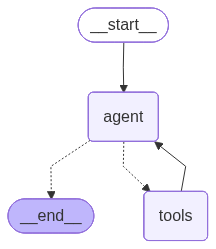

In [8]:
Image(graph_compiled.get_graph().draw_mermaid_png())

### Invoke the Graph

In [9]:
output = graph_compiled.invoke({'messages': [
    ('user', 'Write a simple report on how to use AI for productivity.')
]})

output

Last message: content='To use AI for productivity, start by identifying tasks that can be automated, such as data entry or email management. Implement AI-powered tools, like virtual assistants or project management software, to streamline these tasks and free up time for more complex and creative work. Additionally, utilize AI-driven analytics to gain insights into your work habits and patterns, allowing you to optimize your workflow and make data-driven decisions. Finally, explore AI-based tools for note-taking, organization, and time management to further enhance your productivity. By leveraging these AI solutions, you can increase efficiency, reduce stress, and achieve your goals more effectively.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 290, 'total_tokens': 412, 'completion_time': 0.360835344, 'completion_tokens_details': None, 'prompt_time': 0.04403518, 'prompt_tokens_details': None, 'queue_time': 0.052297031, 'total_time'

{'messages': [HumanMessage(content='Write a simple report on how to use AI for productivity.', additional_kwargs={}, response_metadata={}, id='0a028734-b3a2-47f5-bf10-fcc220fc6404'),
  AIMessage(content='To use AI for productivity, start by identifying tasks that can be automated, such as data entry or email management. Implement AI-powered tools, like virtual assistants or project management software, to streamline these tasks and free up time for more complex and creative work. Additionally, utilize AI-driven analytics to gain insights into your work habits and patterns, allowing you to optimize your workflow and make data-driven decisions. Finally, explore AI-based tools for note-taking, organization, and time management to further enhance your productivity. By leveraging these AI solutions, you can increase efficiency, reduce stress, and achieve your goals more effectively.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 290, 't

In [10]:
print(output["messages"][0].content)

Write a simple report on how to use AI for productivity.


In [11]:
print(output["messages"][-1].content)

To use AI for productivity, start by identifying tasks that can be automated, such as data entry or email management. Implement AI-powered tools, like virtual assistants or project management software, to streamline these tasks and free up time for more complex and creative work. Additionally, utilize AI-driven analytics to gain insights into your work habits and patterns, allowing you to optimize your workflow and make data-driven decisions. Finally, explore AI-based tools for note-taking, organization, and time management to further enhance your productivity. By leveraging these AI solutions, you can increase efficiency, reduce stress, and achieve your goals more effectively.


In [12]:
output = graph_compiled.invoke({'messages': [
    ('user', 'What is the latest news on OpenAI product releases.')
]})

output

Last message: content='' additional_kwargs={'tool_calls': [{'id': 'tntm21kr5', 'function': {'arguments': '{"query":"OpenAI latest product releases"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 289, 'total_tokens': 311, 'completion_time': 0.06219936, 'completion_tokens_details': None, 'prompt_time': 0.028101885, 'prompt_tokens_details': None, 'queue_time': 0.056971455, 'total_time': 0.090301245}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019be84c-608f-7983-a97c-2cabebc3609c-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'OpenAI latest product releases'}, 'id': 'tntm21kr5', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 289, 'output_tokens': 22, 'total_tokens': 311}
Last message: content="

{'messages': [HumanMessage(content='What is the latest news on OpenAI product releases.', additional_kwargs={}, response_metadata={}, id='4c3755f0-2ba7-4249-8bb4-aec4e1609fe5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tntm21kr5', 'function': {'arguments': '{"query":"OpenAI latest product releases"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 289, 'total_tokens': 311, 'completion_time': 0.06219936, 'completion_tokens_details': None, 'prompt_time': 0.028101885, 'prompt_tokens_details': None, 'queue_time': 0.056971455, 'total_time': 0.090301245}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019be84c-608f-7983-a97c-2cabebc3609c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'OpenAI latest produ